In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import time
from bs4 import BeautifulSoup
import twint
import nest_asyncio
nest_asyncio.apply()

### Webscraping

In [ ]:
url = "https://triagecancer.org/congressional-social-media"
soup = BeautifulSoup(requests.get(url).text)

In [ ]:
containers = [soup.findAll('tr', {"class": f"ninja_table_row_{num}"}) for num in range(541)]

In [ ]:
names = [c[0].findAll("td")[2].text for c in containers]

In [ ]:
parties = [c[0].findAll("td")[4].text for c in containers]

In [ ]:
handles = [c[0].findAll("td")[5].text for c in containers]

In [ ]:
twitter_df = pd.DataFrame(columns = ["name", "party", "t_handle"])
twitter_df["name"] = names
twitter_df["party"] = parties
twitter_df["t_handle"] = handles

In [ ]:
twitter_df["t_handle"] = twitter_df["t_handle"].map(lambda x: x.strip("@"))

In [ ]:
add_names = ["Biden, Joe", "Clinton, Hillary", "Obama, Barack", "Pence, Mike", "Pompeo, Mike"]
add_parties = ["D", "D", "D", "R", "R"]
add_handles = ["JoeBiden", "HillaryClinton", "BarackObama", "Mike_Pence", "mikepompeo"]
d = {'name': add_names, 'party': add_parties, 't_handle': add_handles}
add_df = pd.DataFrame(data=d)

In [ ]:
twitter_df = twitter_df.append(add_df)

In [ ]:
most_popular = twitter_df[twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

In [ ]:
less_popular = twitter_df[~twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

### Extracting Data from Twint

In [ ]:
def extract_twint(user, since, min_likes):
    c = twint.Config()
    c.Username = user
    c.Since = since
    c.Lang = "en"
    c.Min_likes = min_likes
    c.Popular_tweets = True
    c.Pandas = True
    c.Hide_output = True
    twint.run.Search(c)
    df = twint.storage.panda.Tweets_df
    return df

In [ ]:
def extract_all(df, since, min_likes):
    users = list(df["t_handle"])
    data = pd.DataFrame([])
    for u in users:
        try:
            u_df = extract_twint(u, since, min_likes)
            data = data.append(u_df)
        except ValueError:
            continue
    return data

In [ ]:
tweets_less = extract_all(less_popular,'2016-01-01', 50)

In [ ]:
tweets_more = extract_all(most_popular,'2016-01-01', 500)

In [ ]:
tweets_less.shape

In [ ]:
tweets_less = tweets_less[tweets_less["language"] == "en"]

In [ ]:
tweets_all = tweets_less.append(tweets_more)

In [ ]:
tweets_all = tweets_all[tweets_all["language"] == "en"]

In [ ]:
tweets_all = tweets_all[["id", "date", "tweet", "language", "username", "nlikes", "hashtags"]]

In [ ]:
tweets_all["characters"] = tweets_all["tweet"].map(lambda x: len(x))

In [ ]:
tweets_all.to_csv("Data/tweets_all.csv")

In [ ]:
tweets_all = pd.read_csv("Data/tweets_all.csv")

In [ ]:
tweets_all.drop(columns = "Unnamed: 0", inplace=True)

In [ ]:
twitter_df.rename(columns={"t_handle": "username"}, inplace=True)

In [ ]:
expanded_df = tweets_all.join(twitter_df.set_index("username"), on="username", how="left")

In [ ]:
cols = ['id', 'name', 'username', 'date', 'tweet', 'characters', 'language', 'nlikes', 'hashtags','party']
expanded_df = expanded_df[cols]

In [ ]:
expanded_df = expanded_df[expanded_df["characters"] > 50]

In [ ]:
expanded_df["date"] = pd.to_datetime(expanded_df["date"])

In [ ]:
expanded_df.drop_duplicates(subset="id", inplace=True)

In [ ]:
expanded_df.head()

Since there are tweets from only two independent politicians, we will either drop them or label them as republican or democrat. We will drop Angus King, but label Bernie Sanders as "D", due to him running under the democratic party during the 2020 election.

In [5]:
expanded_df.drop(expanded_df[expanded_df['name'] == "Angus King"].index, inplace = True)

In [6]:
expanded_df.loc[(expanded_df["name"] == 'Sanders, Bernie'),"party"]="D"

We will now check for Nan values

In [7]:
expanded_df.isna().sum()

id                0
name          22491
username          0
date              0
tweet             0
characters        0
language          0
nlikes            0
hashtags          0
party         22491
dtype: int64

In [8]:
expanded_df.loc[(expanded_df["party"] != 'R')&(expanded_df["party"] != 'D')]["username"].value_counts()[:50]

justinamash        3267
SenatorTomUdall    2411
mattgaetz          2018
RepDougCollins     1589
DougJones          1277
TulsiPress         1159
SteveKingIA        1011
RepDavids           803
SenCoryGardner      793
RepCunningham       636
sendavidperdue      625
RepDMP              598
SenatorLoeffler     579
repjohnlewis        526
HurdOnTheHill       514
RepHarley           441
RepMarkWalker       414
RepRiggleman        398
SenAlexander        326
braun4indiana       291
RepPeteKing         281
RepEliotEngel       243
RepTedYoho          199
RepByrne            163
NitaLowey           122
RepTorresSmall      118
LacyClayMO1         104
RepMaxRose          103
andybiggs4az        102
JimLangevin          89
SenPatRoberts        80
RepRossSpano         73
repgregwalden        73
RepAbraham           73
RepKirkpatrick       73
RepGilCisneros       70
jamie_raskin         66
RepBrindisi          62
RepJoseSerrano       60
SusanWBrooks         59
RepFinkenauer        58
RepMikeRogersAL 

To preserve data, we will label the politicians that do not have a party based on their political affiliations.

In [9]:
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"name"]="Udall, Tom"

In [10]:
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"name"]="Gaetz, Matt"

In [11]:
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"name"]="Collins, Doug"

In [12]:
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"name"]="Jones, Doug"

In [13]:
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"name"]="Gabbard, Tulsi"

In [14]:
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"name"]="King, Steve"

In [15]:
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"name"]="Davids, Sharice"

In [16]:
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"name"]="Gardner, Cory"

In [17]:
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"name"]="Cunningham, Joe"

In [18]:
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"name"]="Perdue, David"

In [19]:
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"name"]="Mucarsel-Powell, Debbie"

In [20]:
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"name"]="Loeffler, Kelly"

In [21]:
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"name"]="Lewis, John"

In [22]:
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"name"]="Hurd, Will"

In [23]:
expanded_df.dropna(inplace=True)

### Data Preprocessing and EDA

In [2]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import re
import preprocessor as p
import spacy
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess

In [25]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words("english")

We will add some additional words and characters to the stopwords list based on previous results.

In [26]:
stopwords_list.append("&amp")
stopwords_list.append("amp")
stopwords_list.append("ca")
stopwords_list.append("nt")
stopwords_list.append("s")
stopwords_list.append("'s")
stopwords_list.append("ve")
stopwords_list.append("w")
stopwords_list.append("u")
stopwords_list.append("be")

In [27]:
def process_text(text, pattern):
    text = p.clean(text)
    raw = nltk.regexp_tokenize(text, pattern)
    lower_tokens = [w.lower() for w in raw]
    words_stopped = [w for w in lower_tokens if w not in stopwords_list]
    separator = ' '
    sentence = separator.join(words_stopped)
    return sentence

In [28]:
def lemmatize(text):
    w_ls = []
    for word in nlp(text):
        w_ls.append(word.lemma_)
    words_stopped = [w for w in w_ls if w not in stopwords_list]
    separator = ' '
    sentence = separator.join(words_stopped)
    return sentence

In [29]:
preprocess = expanded_df.copy()

In [30]:
preprocess["tokens"] = preprocess["tweet"].map(lambda x: process_text(x, pattern))

In [31]:
preprocess["lemmatized"] = preprocess["tokens"].map(lambda x: lemmatize(x))

In [32]:
preprocess.head()

,id,name,username,date,tweet,characters,language,nlikes,hashtags,party,tokens,lemmatized
0,1358826533310390272,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,"Although I plan to retire, I am not leaving to...",270,en,154,[],R,although plan retire leaving today two good ye...,although plan retire leave today two good year...
1,1358826532450541573,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,Today I announce that I will not seek a sevent...,232,en,617,[],R,today announce seek seventh term senate everyt...,today announce seek seventh term senate everyt...
2,1358538474639544321,"Shelby, Richard",SenShelby,2021-02-07 16:09:47,George Shultz was a great statesman. He held f...,206,en,112,[],R,george shultz great statesman held four cabine...,george shultz great statesman hold four cabine...
3,1357132614071689217,"Shelby, Richard",SenShelby,2021-02-03 19:03:24,"Congratulations to Ann Berry, the new Secretar...",275,en,220,[],R,congratulations ann berry new secretary senate...,congratulation ann berry new secretary senate ...
4,1357059443435991046,"Shelby, Richard",SenShelby,2021-02-03 14:12:38,"Cosponsored a resolution, which just passed in...",279,en,144,[],R,cosponsored resolution passed senate honoring ...,cosponsor resolution pass senate honor life le...


In [37]:
preprocess["lemmatized"].str.split(expand=True).stack().value_counts()[:50]

trump         53769
american      53418
today         40148
president     39675
people        37988
need          37478
make          36010
work          35478
must          32322
I             31637
family        29867
get           28304
right         27389
time          27217
vote          27154
health        25121
year          24776
one           24275
day           24197
bill          23968
act           23521
country       23009
fight         23001
congress      22873
care          22827
take          22709
senate        22576
house         22149
state         21270
help          21021
go            19712
republican    19634
pass          19587
would         19343
support       19199
protect       18569
thank         17941
new           17699
america       17648
woman         17335
say           16521
community     16447
know          16393
like          16123
keep          16042
call          16036
law           15978
every         15741
continue      15623
million       15590


We will check for and drop Nan values from the tokenized and lemmatized tweets.

In [60]:
preprocess.dropna(inplace = True)

In [ ]:
#banned = []
#f = lambda x: ' '.join([item for item in x.split() if item not in banned])
#preprocess["tokens"] = preprocess["tokens"].map(f)

In [ ]:
##preprocess["freq_dist"] = preprocess["tokens"].map(lambda x: FreqDist(x))

In [11]:
## Each word always going to be a column? Just categorical variables with some words? How do you set up your dataframe? 

In [ ]:
## Total words/vocab before removal of stop words? 
#Consider removing tweets with congratulations and thank you
# Turn df into preprocess instead of EDA
# create column for lemmatization

In [61]:
preprocess.to_csv("Data/preprocess.csv", index=False)

In [3]:
preprocess = pd.read_csv("Data/preprocess.csv")

In [63]:
eda = preprocess.copy()

We will now split the dataframe into classes for the EDA.

In [65]:
right = eda[eda["party"] == "R"]
left = eda[eda["party"] == "D"]

In [66]:
right.describe()

,id,characters,nlikes
count,9.857100e+04,98571.000000,98571.000000
mean,1.135182e+18,195.346380,2227.821377
std,1.690822e+17,72.691264,6572.643177
min,6.829092e+17,51.000000,0.000000
25%,1.023600e+18,135.000000,152.000000
50%,1.185216e+18,197.000000,377.000000
75%,1.269321e+18,267.000000,1432.000000
max,1.359657e+18,500.000000,227274.000000


In [67]:
left.describe()

,id,characters,nlikes
count,3.034470e+05,303447.000000,3.034470e+05
mean,1.077435e+18,198.673409,4.572446e+03
std,1.772615e+17,68.966159,3.151070e+04
min,6.828041e+17,51.000000,1.200000e+01
25%,9.258824e+17,139.000000,1.390000e+02
50%,1.091530e+18,198.000000,3.400000e+02
75%,1.233545e+18,267.000000,1.531000e+03
max,1.359659e+18,777.000000,4.281004e+06


Looking at the descriptive statistics for the two classes, both has similar average character length of tweets (195 vs 198), but left leaning politicians recieved significantly more likes on average. 

In [68]:
left["nlikes"].median(), right["nlikes"].median()

(340.0, 377.0)

However, the medians in terms of likes were much more similar.

We will now look at the most common words per class.

In [69]:
right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

american     0.008582
today        0.006570
work         0.005386
president    0.005186
people       0.005134
time         0.004446
need         0.004402
make         0.004278
great        0.004241
vote         0.004052
dtype: float64

In [70]:
left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

trump        0.010182
american     0.008277
president    0.006524
need         0.006320
people       0.006193
today        0.006183
make         0.006057
must         0.005694
work         0.005596
I            0.005356
dtype: float64

The most common 10 words in each class are fairly similar, albeit in slightly different proportions. The most commonly used word in left leaning tweets was "Trump" while in right leaning it was "american".

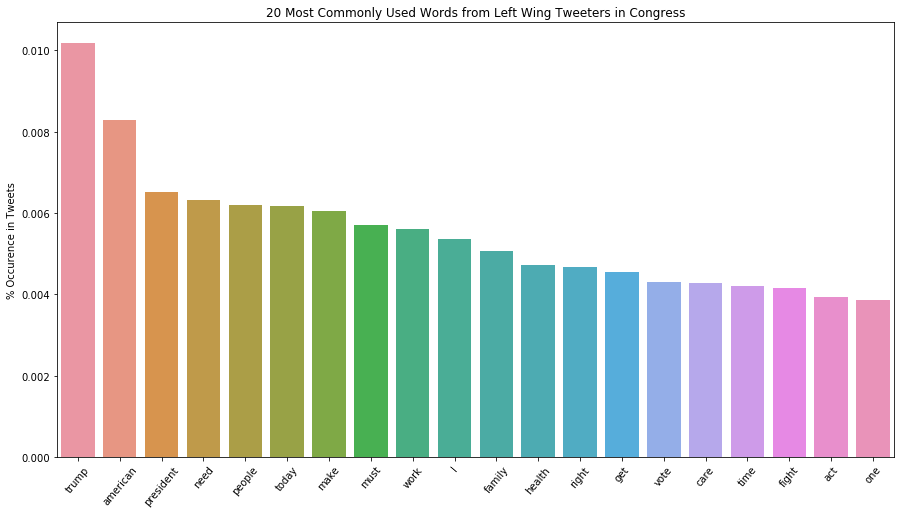

In [71]:
plt.figure(figsize=(15,8))
sns.barplot(x=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Left Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

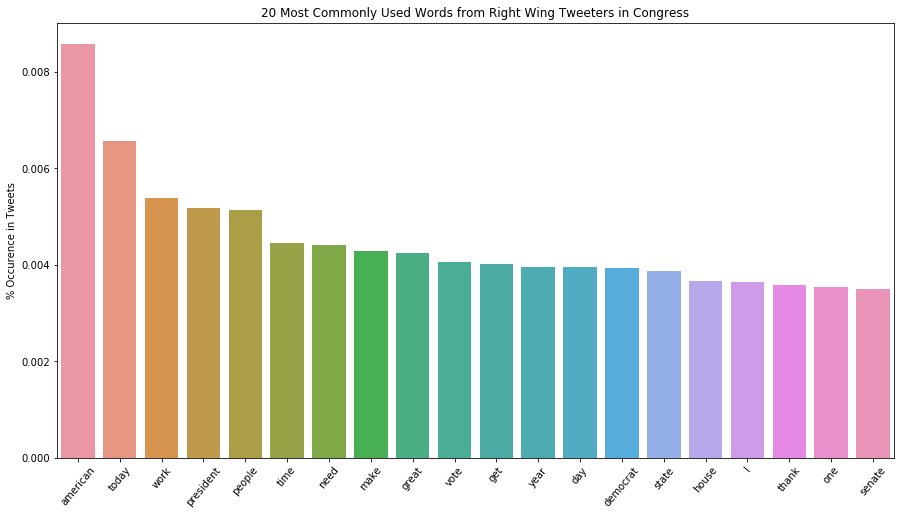

In [72]:
plt.figure(figsize=(15,8))
sns.barplot(x=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Right Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

Another way to visualize the most commonly used words for each class is through word clouds, where the more commonly used words are represented in bigger text.

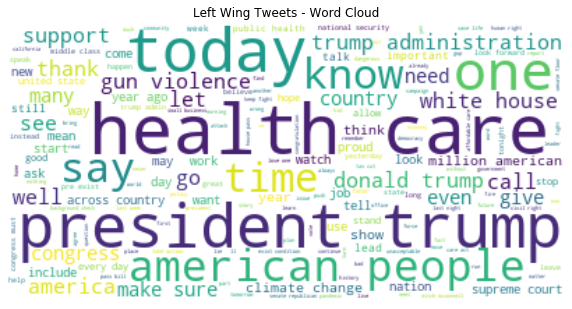

In [74]:
plt.figure(figsize=(10, 8))
left_text = " ".join(tweet for tweet in left["lemmatized"])
wordcloud_l = WordCloud(background_color="white").generate(left_text)
plt.imshow(wordcloud_l, interpolation='bilinear')
plt.axis("off")
plt.title("Left Wing Tweets - Word Cloud")
plt.show()

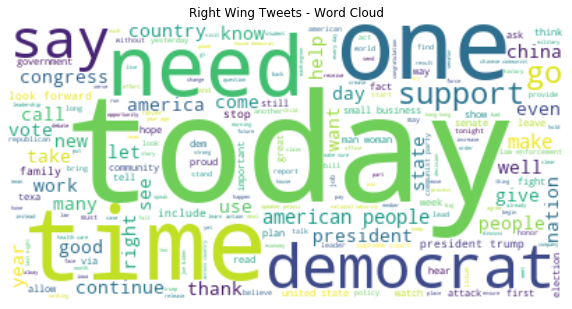

In [75]:
plt.figure(figsize=(10, 8))
right_text = " ".join(tweet for tweet in right["lemmatized"])
wordcloud_r = WordCloud(background_color="white").generate(right_text)
plt.imshow(wordcloud_r, interpolation='bilinear')
plt.axis("off")
plt.title("Right Wing Tweets - Word Cloud")
plt.show()

We will now perform LDA (latent dirichlet allocation) to form topic clusters out of the words in each class.

In [76]:
def list_tokens_lemmas(df, col):
    tokens_list = []
    for sentence in df[col]:
        word_list = []
        for word in sentence.split(" "):
            word_list.append(word)
        tokens_list.append(word_list)
    return tokens_list

In [77]:
left_tokens = list_tokens_lemmas(left, "lemmatized")
right_tokens = list_tokens_lemmas(right, "lemmatized")

In [78]:
left_dict = gensim.corpora.Dictionary(left_tokens)
right_dict = gensim.corpora.Dictionary(right_tokens)

In [79]:
left_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
right_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [80]:
left_corpus = [left_dict.doc2bow(text) for text in left_tokens]
right_corpus = [right_dict.doc2bow(text) for text in right_tokens]

In [81]:
left_lda =  gensim.models.LdaMulticore(left_corpus, 
                                   num_topics = 5, 
                                   id2word = left_dict,                                    
                                   passes = 10,
                                   workers = 2)
left_lda.print_topics()

[(0,
  '0.016*"pay" + 0.011*"worker" + 0.011*"tax" + 0.011*"work" + 0.010*"make" + 0.009*"job" + 0.009*"climate" + 0.009*"family" + 0.008*"need" + 0.008*"cut"'),
 (1,
  '0.016*"vote" + 0.014*"I" + 0.013*"get" + 0.013*"make" + 0.012*"today" + 0.011*"day" + 0.009*"gun" + 0.008*"go" + 0.008*"time" + 0.008*"work"'),
 (2,
  '0.014*"woman" + 0.013*"country" + 0.011*"right" + 0.011*"today" + 0.010*"fight" + 0.010*"year" + 0.009*"nation" + 0.009*"family" + 0.009*"america" + 0.009*"stand"'),
 (3,
  '0.030*"health" + 0.029*"care" + 0.015*"need" + 0.012*"act" + 0.011*"people" + 0.011*"million" + 0.011*"right" + 0.010*"must" + 0.010*"family" + 0.009*"bill"'),
 (4,
  '0.028*"president" + 0.010*"donald" + 0.008*"must" + 0.007*"election" + 0.007*"people" + 0.007*"republican" + 0.007*"say" + 0.006*"congress" + 0.006*"house" + 0.006*"hillary"')]

Some of the topic clusters for left leaning tweets may be related to the 2020 election, health care, legislation, COVID relief.

In [82]:
right_lda =  gensim.models.LdaMulticore(right_corpus, 
                                   num_topics = 5, 
                                   id2word = right_dict,                                    
                                   passes = 10,
                                   workers = 2)
right_lda.print_topics()

[(0,
  '0.015*"today" + 0.013*"president" + 0.013*"year" + 0.013*"day" + 0.012*"great" + 0.012*"thank" + 0.012*"america" + 0.011*"life" + 0.011*"nation" + 0.011*"honor"'),
 (1,
  '0.013*"border" + 0.011*"china" + 0.011*"act" + 0.010*"security" + 0.009*"must" + 0.008*"support" + 0.007*"bill" + 0.007*"law" + 0.007*"protect" + 0.007*"right"'),
 (2,
  '0.018*"great" + 0.017*"today" + 0.016*"join" + 0.011*"discuss" + 0.010*"thank" + 0.009*"morning" + 0.009*"texas" + 0.009*"watch" + 0.009*"tonight" + 0.009*"I"'),
 (3,
  '0.015*"vote" + 0.014*"democrat" + 0.012*"president" + 0.011*"house" + 0.009*"election" + 0.009*"people" + 0.008*"impeachment" + 0.008*"say" + 0.008*"senate" + 0.007*"trump"'),
 (4,
  '0.015*"job" + 0.014*"work" + 0.012*"need" + 0.009*"business" + 0.009*"get" + 0.008*"help" + 0.008*"people" + 0.008*"economy" + 0.007*"america" + 0.007*"year"')]

Some topic clusters for right leaning tweets may include 2020 election, national security and the economy.

We will now investigate the top and most frequent tweeters from both classes

In [83]:
print("Some of the most frequent tweeters in the last four years from the right side include: \n")
for name in right["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(right["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last four years from the right side include: 

Rubio, Marco
Cruz, Ted
Cornyn, John
Paul, Rand
Blackburn, Marsha

Accounting for a total of 28027 tweets


In [84]:
print("Some of the most frequent tweeters in the last four years from the left side include: \n")
for name in left["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(left["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last four years from the left side include: 

Padilla, Alex
Murphy, Chris
Schumer, Chuck
Durbin, Richard
Klobuchar, Amy

Accounting for a total of 42099 tweets


In [85]:
print("Some of the most popular tweeters in the last four years from the right side include: \n")
for name in right.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweets".format(round(right.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last four years from the right side include: 

Jordan, Jim
Pompeo, Mike
Pence, Mike
Nunes, Devin
McCarthy, Kevin

Accounting for an average of 10524.96 likes per tweets


In [86]:
print("Some of the most popular tweeters in the last four years from the left side include: \n")
for name in left.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweets".format(round(left.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last four years from the left side include: 

Obama, Barack
Biden, Joe
Schiff, Adam
Lewis, John
Clinton, Hillary

Accounting for an average of 46698.36 likes per tweets


### Text Prep and Initial Modeling

We will now prepare the data and run some classification models. There are a few ways to process text data so it can be run through machine learning algorithms:
 - Bag of Words Methods
     - Count Vectorization: Creates "word count" vectors for each document. Each vector is the size of the total vocabulary
     - TF-IDF: Term Frequency Inverse Document Frequency. Words are represented numerically based on their frequency of occurence. Words that occur less frequently are considered more important and therefore carry a heavier weight. 
 - Word Embeddings: Learned numerical representation for words. Words that have more similar meanings are represented similarly.
 - Document Embeddings: Learned numerical representation for entire document/text. Documents with similar meanings are represented similarly.
 
We will include each of these methods in our pipelines to process the data before it is classified.

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
import gensim.downloader as api
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.sklearn_api import D2VTransformer
from gensim.sklearn_api import W2VTransformer
np.random.seed(42)
random_state = 42

Before we begin modeling, we divide our dataframe into the class features (lemmatized words in each tweet) and the class label corresponding to the tweet ("D" for democrat, "R" for republican). We will then perform a train test split so our model can be tested on unseen data.

In [91]:
X = preprocess["lemmatized"]
y = preprocess["party"]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [7]:
def return_classification_report(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_train_preds = pipeline.predict(X_train)
    y_test_preds = pipeline.predict(X_test)
    train = pd.DataFrame(classification_report(y_train, y_train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    test = pd.DataFrame(classification_report(y_test, y_test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return pd.concat([train, test], axis=1, keys=["Train Scores {}".format(str(pipeline.steps[-1][1]).strip("()")),
                                                 "Test Scores {}".format(str(pipeline.steps[-1][1]).strip("()"))])

In [8]:
def plot_feature_importances(pipeline, n_features):
    n = n_features
    feature_ls = list(zip(pipeline["t_proc"].get_feature_names(), pipeline["clf"].feature_importances_))
    top_features = sorted(feature_ls, key=lambda x: x[1], reverse=True)[:n]
    plt.figure(figsize=(15, 20))
    plt.barh(range(n), list(map(lambda x: x[1], top_features)), align='center') 
    plt.yticks(np.arange(n),list(map(lambda x: x[0], top_features))) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [135]:
def tokenize(series):
    t_series = series.map(lambda x: list(x.split(" ")))
    return list(t_series)

#### Bag of Words Methods for Text Processing

We will include count vectorization and TF-IDF in our pipelines to represent the tweets in the form of a vector. Due to the large size of the dataset, we will limit the max features to the 1000 most important words. This will help with processing time and memory. We will run some initial models (logistic regression, naive bayes, random forest) to get baseline and tune accordingly.

##### Count Vectorization

In [93]:
pipe_lr1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                     ('clf', LogisticRegression())])

In [94]:
return_classification_report(pipe_lr1, X_train, y_train, X_test, y_test)

Train Scores LogisticRegression                             \
                                   precision recall f1-score    support   
D                                       0.82   0.95     0.88  212231.00   
R                                       0.72   0.38     0.50   69181.00   
accuracy                                0.81   0.81     0.81       0.81   
macro avg                               0.77   0.67     0.69  281412.00   
weighted avg                            0.80   0.81     0.79  281412.00   

             Test Scores LogisticRegression                             
                                  precision recall f1-score    support  
D                                      0.82   0.95     0.88   91216.00  
R                                      0.71   0.37     0.49   29390.00  
accuracy                               0.81   0.81     0.81       0.81  
macro avg                              0.77   0.66     0.68  120606.00  
weighted avg                           0.80   0.81     0.79  120606.00

The model's accuracy is fair at 81%, but lacks in recall for the "R" class (out of all the actual republican tweets, the model was only able to identify 37% of them). To increase the model's ability to distinguish between classes, we will try SMOTING (Synthetic Minority Oversampling TEchnique) the data to rebalance the classes.

In [95]:
pipe_lr2 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('clf', LogisticRegression())])

In [96]:
return_classification_report(pipe_lr2, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

While accuracy has decreased to 74%, recall for the R class has increased to 59%, (out of all the actual republican tweets the model was able to correctly identify 59% of them).

We will now try a random forest classifier to identify feature importances.

In [154]:
pipe_rf1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=20))])

In [155]:
return_classification_report(pipe_rf1, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=20                  \
                                                    precision recall f1-score   
D                                                        0.86   0.70     0.77   
R                                                        0.42   0.66     0.51   
accuracy                                                 0.69   0.69     0.69   
macro avg                                                0.64   0.68     0.64   
weighted avg                                             0.75   0.69     0.71   

                        Test Scores RandomForestClassifier(max_depth=20  \
                support                                       precision   
D             121108.00                                            0.84   
R              39699.00                                            0.39   
accuracy           0.69                                            0.67   
macro avg     160807.00                                            0.62   
weighted avg  160807.00                                            0.73   

                                         
             recall f1-score    support  
D              0.69     0.76  182339.00  
R              0.61     0.47   58872.00  
accuracy       0.67     0.67       0.67  
macro avg      0.65     0.62  241211.00  
weighted avg   0.67     0.69  241211.00

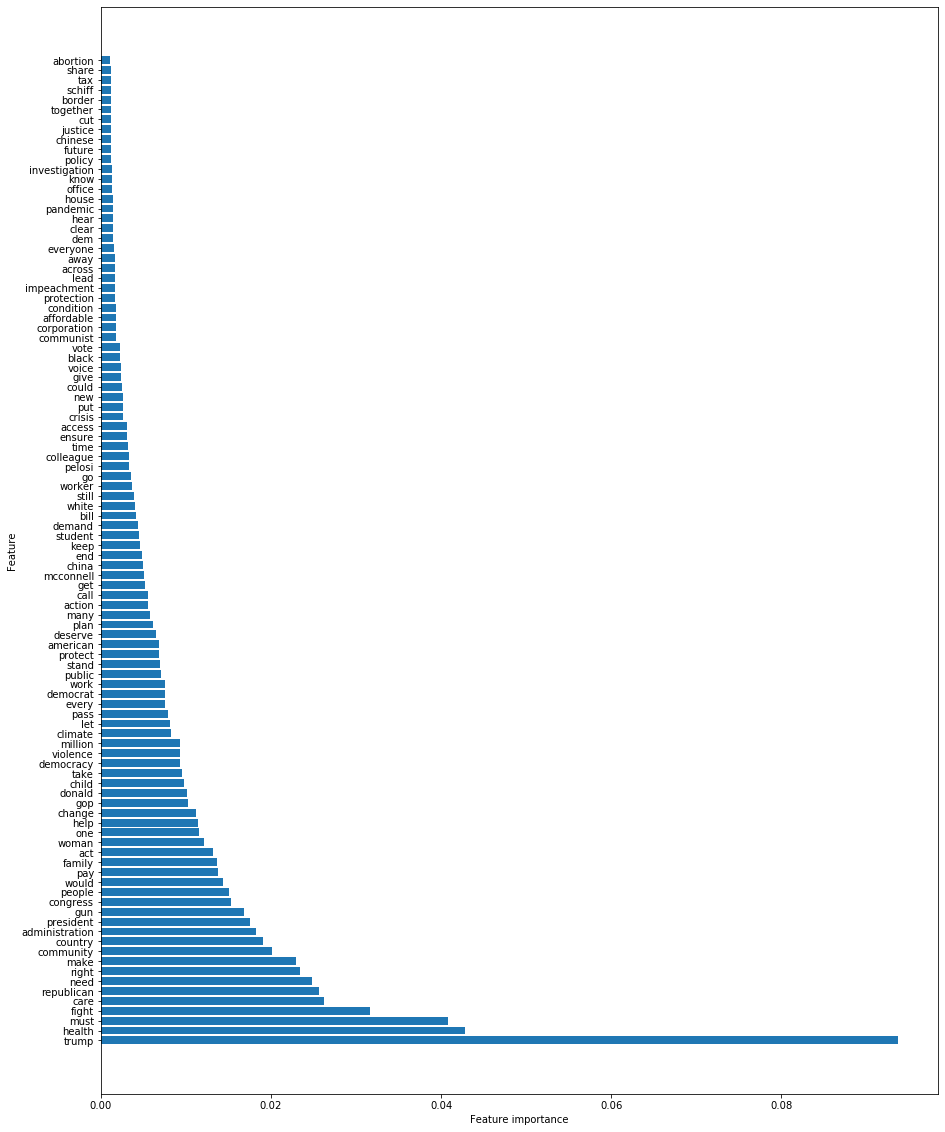

In [158]:
plot_feature_importances(pipe_rf1, 100)

The random forest classifier performed with less accuracy than logistic regression. However, one can identify the most important words in determining a class: 
- Trump
- Health
- Must
- Fight
- Care

In [159]:
pipe_nb1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                    ('to_dense', DenseTransformer()),
                     ('clf', GaussianNB())])

In [160]:
return_classification_report(pipe_nb1, X_train, y_train, X_test, y_test)

Train Scores GaussianNB                             \
                           precision recall f1-score    support   
D                               0.81   0.74     0.78  121108.00   
R                               0.38   0.48     0.42   39699.00   
accuracy                        0.68   0.68     0.68       0.68   
macro avg                       0.60   0.61     0.60  160807.00   
weighted avg                    0.71   0.68     0.69  160807.00   

             Test Scores GaussianNB                             
                          precision recall f1-score    support  
D                              0.82   0.75     0.78  182339.00  
R                              0.38   0.48     0.42   58872.00  
accuracy                       0.68   0.68     0.68       0.68  
macro avg                      0.60   0.61     0.60  241211.00  
weighted avg                   0.71   0.68     0.69  241211.00

##### TF-IDF

In [16]:
pipe_lr3 = Pipeline([('t_proc', TfidfVectorizer(max_features=1000)),
                     ("sm", SMOTE(random_state=random_state)),
                     ('clf', LogisticRegression())])

In [17]:
return_classification_report(pipe_lr3, X_train, y_train, X_test, y_test)

Train Scores LogisticRegression                             \
                                   precision recall f1-score    support   
D                                       0.87   0.79     0.83  121108.00   
R                                       0.50   0.64     0.56   39699.00   
accuracy                                0.75   0.75     0.75       0.75   
macro avg                               0.69   0.72     0.70  160807.00   
weighted avg                            0.78   0.75     0.76  160807.00   

             Test Scores LogisticRegression                             
                                  precision recall f1-score    support  
D                                      0.87   0.79     0.83  182339.00  
R                                      0.49   0.63     0.55   58872.00  
accuracy                               0.75   0.75     0.75       0.75  
macro avg                              0.68   0.71     0.69  241211.00  
weighted avg                           0.78   0.75     0.76  241211.00

The TF-IDF vectorizer performed slightly better than the Count Vectorizer when using Logistic Regression.

In [18]:
pipe_rf2 = Pipeline([('t_proc',  TfidfVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=20))])

In [21]:
return_classification_report(pipe_rf2, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=20                  \
                                                    precision recall f1-score   
D                                                        0.87   0.71     0.78   
R                                                        0.44   0.68     0.53   
accuracy                                                 0.70   0.70     0.70   
macro avg                                                0.65   0.70     0.66   
weighted avg                                             0.76   0.70     0.72   

                       Test Scores RandomForestClassifier(max_depth=20         \
               support                                       precision recall   
D             121108.0                                            0.86   0.70   
R              39699.0                                            0.41   0.63   
accuracy           0.7                                            0.69   0.69   
macro avg     160807.0                                            0.63   0.67   
weighted avg  160807.0                                            0.75   0.69   

                                  
             f1-score    support  
D                0.77  182339.00  
R                0.49   58872.00  
accuracy         0.69       0.69  
macro avg        0.63  241211.00  
weighted avg     0.70  241211.00

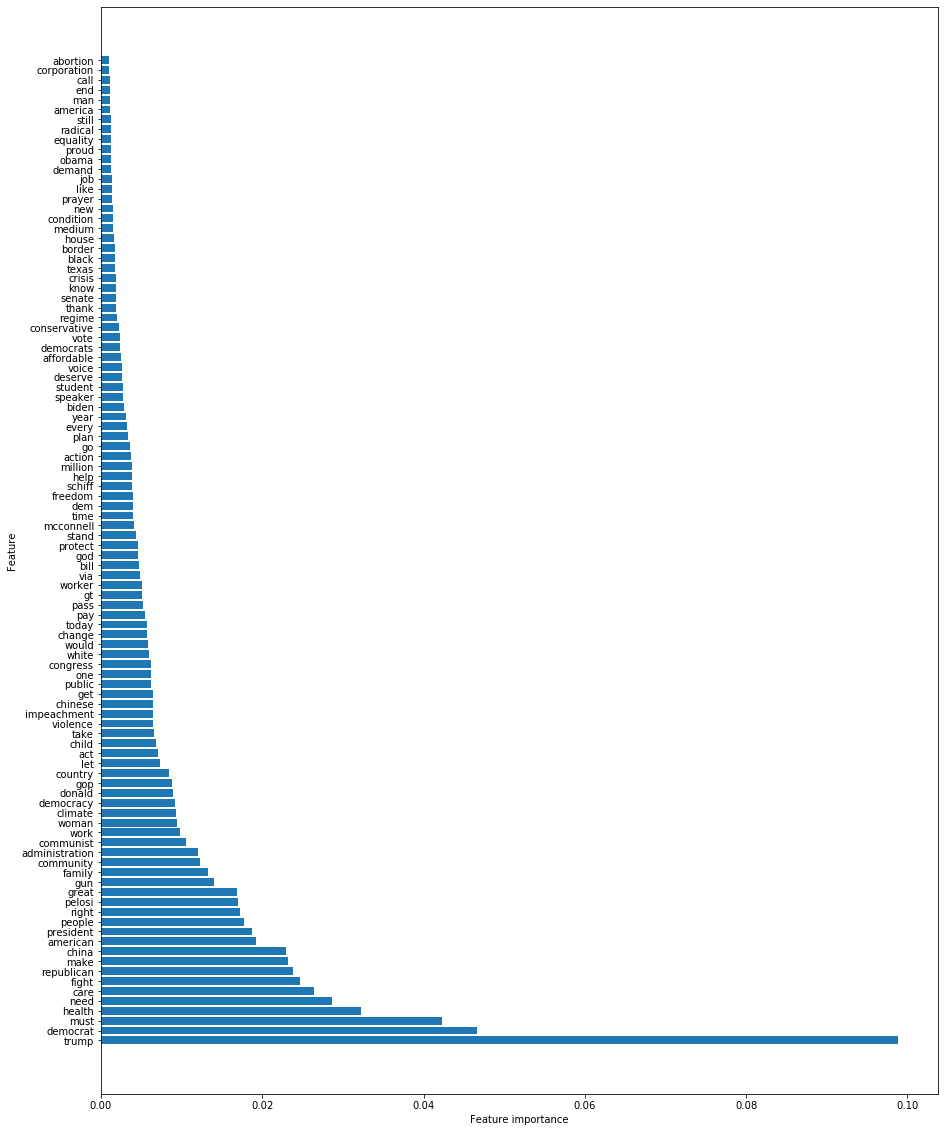

In [22]:
plot_feature_importances(pipe_rf2, 100)

There are slight differences between the feature importances with Count Vectorizer vs TF-IDF. For example, the word democrat was fairly important when determining a class after using the TF-IDF vectorizer.

In [23]:
pipe_nb2 = Pipeline([('t_proc', TfidfVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                    ('to_dense', DenseTransformer()),
                     ('clf', GaussianNB())])

In [24]:
return_classification_report(pipe_nb2, X_train, y_train, X_test, y_test)

Train Scores GaussianNB                             \
                           precision recall f1-score    support   
D                               0.86   0.75     0.80  121108.00   
R                               0.44   0.62     0.52   39699.00   
accuracy                        0.71   0.71     0.71       0.71   
macro avg                       0.65   0.68     0.66  160807.00   
weighted avg                    0.75   0.71     0.73  160807.00   

             Test Scores GaussianNB                             
                          precision recall f1-score    support  
D                              0.86   0.75     0.80  182339.00  
R                              0.44   0.61     0.51   58872.00  
accuracy                       0.71   0.71     0.71       0.71  
macro avg                      0.65   0.68     0.65  241211.00  
weighted avg                   0.75   0.71     0.73  241211.00

Naive Bayes performed similarly to random forest classifier in terms of accuracy. 

#### Word Embeddings

In [133]:
from gensim.test.utils import common_texts

In [142]:
from gensim.models import FastText

In [ ]:
tokenize

In [146]:
model = FastText(size=100, min_count=5, seed=random_state, workers=4)
model.build_vocab(tokenize(X_train))
model.train(tokenize(X_train), total_examples=len(X_train), epochs=10)

In [149]:
model.wv

In [143]:
pipe_lr4 = Pipeline([('t_proc',FastText(size=100, min_count=5, seed=random_state, workers=4)),
                 ("sm", SMOTE(random_state=random_state)),
                 ('clf', LogisticRegression())])

TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' 'FastText(vocab=0, size=100, alpha=0.025)' (type <class 'gensim.models.fasttext.FastText'>) doesn't)

In [140]:
return_classification_report(pipe_lr4, tokenize(X_train), y_train, tokenize(X_test), y_test)

KeyError: "word 'sorta' not in vocabulary"

Word embeddings performed significantly worse than TF-IDF and Count Vectorizer, with an accuracy close to that of random guessing.

In [16]:
pipe_rf3 = Pipeline([('t_proc', Word2Vec(wv, 200)),
                 ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=20))])

In [13]:
return_classification_report(pipe_rf3, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=20                  \
                                                    precision recall f1-score   
D                                                        1.00   0.90     0.95   
R                                                        0.77   1.00     0.87   
accuracy                                                 0.93   0.93     0.93   
macro avg                                                0.88   0.95     0.91   
weighted avg                                             0.94   0.93     0.93   

                        Test Scores RandomForestClassifier(max_depth=20  \
                support                                       precision   
D             121108.00                                            0.78   
R              39699.00                                            0.30   
accuracy           0.93                                            0.63   
macro avg     160807.00                                            0.54   
weighted avg  160807.00                                            0.66   

                                         
             recall f1-score    support  
D              0.72     0.75  182339.00  
R              0.37     0.33   58872.00  
accuracy       0.63     0.63       0.63  
macro avg      0.54     0.54  241211.00  
weighted avg   0.63     0.65  241211.00

In [106]:
pipe_rf4 = Pipeline([('t_proc', Word2Vec(wv, 200)),
                 ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=15))])

In [107]:
return_classification_report(pipe_rf4, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=15                  \
                                                    precision recall f1-score   
D                                                        0.97   0.74     0.84   
R                                                        0.54   0.92     0.68   
accuracy                                                 0.79   0.79     0.79   
macro avg                                                0.75   0.83     0.76   
weighted avg                                             0.86   0.79     0.80   

                        Test Scores RandomForestClassifier(max_depth=15  \
                support                                       precision   
D             212231.00                                            0.79   
R              69181.00                                            0.29   
accuracy           0.79                                            0.59   
macro avg     281412.00                                            0.54   
weighted avg  281412.00                                            0.67   

                                         
             recall f1-score    support  
D              0.63     0.70   91216.00  
R              0.47     0.36   29390.00  
accuracy       0.59     0.59       0.59  
macro avg      0.55     0.53  120606.00  
weighted avg   0.59     0.62  120606.00

#### Document Embeddings

In [59]:
pipe_lr5 = Pipeline([('t_proc', D2VTransformer(min_count=40, size=5)),
                     ("sm", SMOTE(random_state=random_state)),
                 ('clf', LogisticRegression())])

In [60]:
return_classification_report(pipe_lr5, np.array(X_train).reshape(160807, 1), np.array(y_train).reshape(160807, 1), np.array(X_test).reshape(241211, 1), np.array(y_test).reshape(241211, 1))

RuntimeError: you must first build vocabulary before training the model

### Neural Network Modeling

In [97]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.optimizers import SGD

In [98]:
model = Sequential()

model.add(Dense(12, input_dim=1000, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                12012     
_________________________________________________________________
dense_8 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 13        
Total params: 12,181
Trainable params: 12,181
Non-trainable params: 0
_________________________________________________________________


In [99]:
tf_vec = TfidfVectorizer(max_features=1000)

In [100]:
nnX_train = tf_vec.fit_transform(X_train)

In [101]:
nny_train = y_train.map(lambda x: 1 if x == "D" else 0)

In [102]:
nnX_test = tf_vec.transform(X_test)

In [103]:
nny_test = y_test.map(lambda x: 1 if x == "D" else 0)

In [ ]:
    ### Transform X-train, y-train, x-test, y-test with TFIDF, Document embeddings

In [104]:
history = model.fit(nnX_train, 
                      nny_train,
                      epochs=300, 
                      verbose=2, 
                      batch_size=100, 
                      validation_data=(nnX_test, nny_test)) 

Train on 281412 samples, validate on 120606 samples
Epoch 1/300
 - 25s - loss: 0.4377 - accuracy: 0.7990 - val_loss: 0.4199 - val_accuracy: 0.8083
Epoch 2/300
 - 24s - loss: 0.4137 - accuracy: 0.8113 - val_loss: 0.4111 - val_accuracy: 0.8119
Epoch 3/300
 - 23s - loss: 0.4043 - accuracy: 0.8163 - val_loss: 0.4062 - val_accuracy: 0.8142
Epoch 4/300
 - 22s - loss: 0.3971 - accuracy: 0.8204 - val_loss: 0.4035 - val_accuracy: 0.8152
Epoch 5/300
 - 28s - loss: 0.3917 - accuracy: 0.8229 - val_loss: 0.4007 - val_accuracy: 0.8158
Epoch 6/300
 - 31s - loss: 0.3869 - accuracy: 0.8250 - val_loss: 0.3993 - val_accuracy: 0.8181
Epoch 7/300
 - 33s - loss: 0.3825 - accuracy: 0.8272 - val_loss: 0.3988 - val_accuracy: 0.8183
Epoch 8/300
 - 31s - loss: 0.3787 - accuracy: 0.8293 - val_loss: 0.3977 - val_accuracy: 0.8181
Epoch 9/300
 - 32s - loss: 0.3753 - accuracy: 0.8307 - val_loss: 0.3981 - val_accuracy: 0.8194
Epoch 10/300
 - 30s - loss: 0.3726 - accuracy: 0.8323 - val_loss: 0.3973 - val_accuracy: 0.81

Epoch 86/300
 - 30s - loss: 0.3376 - accuracy: 0.8492 - val_loss: 0.4169 - val_accuracy: 0.8124
Epoch 87/300
 - 30s - loss: 0.3376 - accuracy: 0.8493 - val_loss: 0.4162 - val_accuracy: 0.8140
Epoch 88/300
 - 30s - loss: 0.3374 - accuracy: 0.8492 - val_loss: 0.4170 - val_accuracy: 0.8118
Epoch 89/300
 - 30s - loss: 0.3373 - accuracy: 0.8492 - val_loss: 0.4163 - val_accuracy: 0.8122
Epoch 90/300
 - 30s - loss: 0.3372 - accuracy: 0.8496 - val_loss: 0.4183 - val_accuracy: 0.8137
Epoch 91/300
 - 30s - loss: 0.3370 - accuracy: 0.8493 - val_loss: 0.4177 - val_accuracy: 0.8127
Epoch 92/300
 - 31s - loss: 0.3370 - accuracy: 0.8498 - val_loss: 0.4176 - val_accuracy: 0.8121
Epoch 93/300
 - 30s - loss: 0.3370 - accuracy: 0.8499 - val_loss: 0.4179 - val_accuracy: 0.8142
Epoch 94/300
 - 30s - loss: 0.3368 - accuracy: 0.8496 - val_loss: 0.4179 - val_accuracy: 0.8120
Epoch 95/300
 - 30s - loss: 0.3368 - accuracy: 0.8496 - val_loss: 0.4182 - val_accuracy: 0.8131
Epoch 96/300
 - 30s - loss: 0.3368 - acc

Epoch 171/300
 - 30s - loss: 0.3317 - accuracy: 0.8520 - val_loss: 0.4248 - val_accuracy: 0.8122
Epoch 172/300
 - 30s - loss: 0.3314 - accuracy: 0.8523 - val_loss: 0.4242 - val_accuracy: 0.8128
Epoch 173/300
 - 35s - loss: 0.3315 - accuracy: 0.8520 - val_loss: 0.4246 - val_accuracy: 0.8125
Epoch 174/300
 - 33s - loss: 0.3314 - accuracy: 0.8522 - val_loss: 0.4258 - val_accuracy: 0.8124
Epoch 175/300
 - 32s - loss: 0.3314 - accuracy: 0.8526 - val_loss: 0.4255 - val_accuracy: 0.8107
Epoch 176/300
 - 30s - loss: 0.3314 - accuracy: 0.8524 - val_loss: 0.4255 - val_accuracy: 0.8123
Epoch 177/300
 - 30s - loss: 0.3313 - accuracy: 0.8525 - val_loss: 0.4275 - val_accuracy: 0.8061
Epoch 178/300
 - 30s - loss: 0.3313 - accuracy: 0.8524 - val_loss: 0.4249 - val_accuracy: 0.8116
Epoch 179/300
 - 32s - loss: 0.3312 - accuracy: 0.8527 - val_loss: 0.4249 - val_accuracy: 0.8112
Epoch 180/300
 - 30s - loss: 0.3311 - accuracy: 0.8525 - val_loss: 0.4255 - val_accuracy: 0.8082
Epoch 181/300
 - 30s - loss: 0

Epoch 256/300
 - 22s - loss: 0.3292 - accuracy: 0.8536 - val_loss: 0.4286 - val_accuracy: 0.8089
Epoch 257/300
 - 22s - loss: 0.3290 - accuracy: 0.8538 - val_loss: 0.4285 - val_accuracy: 0.8108
Epoch 258/300
 - 22s - loss: 0.3292 - accuracy: 0.8534 - val_loss: 0.4301 - val_accuracy: 0.8106
Epoch 259/300
 - 22s - loss: 0.3290 - accuracy: 0.8534 - val_loss: 0.4286 - val_accuracy: 0.8076
Epoch 260/300
 - 22s - loss: 0.3290 - accuracy: 0.8538 - val_loss: 0.4287 - val_accuracy: 0.8115
Epoch 261/300
 - 23s - loss: 0.3291 - accuracy: 0.8535 - val_loss: 0.4278 - val_accuracy: 0.8087
Epoch 262/300
 - 22s - loss: 0.3289 - accuracy: 0.8538 - val_loss: 0.4282 - val_accuracy: 0.8104
Epoch 263/300
 - 22s - loss: 0.3289 - accuracy: 0.8537 - val_loss: 0.4319 - val_accuracy: 0.8132
Epoch 264/300
 - 22s - loss: 0.3289 - accuracy: 0.8540 - val_loss: 0.4328 - val_accuracy: 0.8021
Epoch 265/300
 - 22s - loss: 0.3290 - accuracy: 0.8536 - val_loss: 0.4314 - val_accuracy: 0.8133
Epoch 266/300
 - 22s - loss: 0

In [105]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

### Parameter Tuning with GridSearch

### Prediction Function and Conclusions

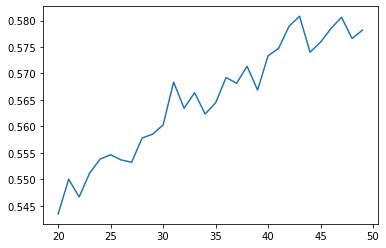

In [88]:
n_comp = []
scores = []
for n in range(50, 80):
    pipe = Pipeline([('t_proc', CountVectorizer()),
                 ("tsvd", TruncatedSVD(n_components=n, random_state=random_state)),
                 ("sm", SMOTE(random_state=random_state)),
                 ('clf', LogisticRegression())])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_train, y_train)
    n_comp.append(n)
    scores.append(score)
sns.lineplot(x=n_comp, y=scores)

In [ ]:
# set max features for count vectorizer, top 1000 tokens. Run without Truncated SVD. Check # of tokens. look at feature importances
# last few importances are close to zero. lowest feature importances above 0.01

In [ ]:
## Data limitations, conclusion is that its hard to distinguish

In [ ]:
## code from google collab notebook. change input dimension to match df. 

In [ ]:
# baselines with models, text processing techniques. 

In [10]:
class Word2Vec(object):
    def __init__(self, wv, dim):
        self.wv = wv
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
         return np.array([np.mean([self.wv[w] for w in text if w in self.wv]
                    or [np.zeros(self.dim)], axis=0) for text in X])

In [47]:
text_processors = [CountVectorizer(), TfidfVectorizer()]
components = 5
classifiers = {LogisticRegression():
               {"clf__C":np.logspace(-3,3,7),
                "clf__penalty":["l1","l2"]},
              RandomForestClassifier():
              {"clf__n_estimators": [10, 30, 100],
                "clf__max_depth": [2, 6, 10],
                "clf__min_samples_split": [2, 5, 10]
                }}

In [45]:
pipe = Pipeline([('clf', RandomForestClassifier
                  ())])

In [46]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

In [48]:
def process_classify_GS(classifiers, text_processors, components):
    for processor in text_processors:
        for key, val in classifiers.items():
            pipe = Pipeline([("t_process", processor),
                             ("tsvd", TruncatedSVD(n_components=components, random_state=random_state)),
                             ('clf', key)])
            search = GridSearchCV(pipe, val, n_jobs=-1)
            search.fit(X_train, y_train)
            print(processor)
            print(key)
            print(search.best_score_)
            print(search.best_params_)

In [35]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
def fit_return_metrics(model, X_train, y_train, X_test, y_test):
    modelf = model.fit(X_train, y_train)
    train_preds = modelf.predict(X_train)
    test_preds = modelf.predict(X_test)
    df_tr = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    df_ts = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return df_tr, df_ts

In [ ]:
def classifier_compare(text_processor, classifiers):
    df_tst = pd.DataFrame()
    df_train = pd.DataFrame()
    for classifier in classifiers:
        train, test = fit_return_metrics(classifier, X_train, y_train, X_test, y_test)
        df_tst = pd.concat([df, test], axis=1)
    pd.concat([xg_ts3, rf_ts3], axis=1, keys=["XGBoost", "Random Forest"])

In [49]:
process_classify_GS(classifiers, text_processors, components)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.75445172        nan 0.75445172        nan 0.75445172
        nan 0.75445172        nan 0.75445172        nan 0.75445172
        nan 0.75445172]
  category=UserWarning


CountVectorizer()
LogisticRegression()
0.754451715188887
{'clf__C': 0.001, 'clf__penalty': 'l2'}


KeyboardInterrupt: 

In [186]:
shortx = X_train[:5]
shorty = y_train[:5]

In [183]:
shortx

'today announce seek seventh term senate everything season grateful people alabama put trust forty year'

In [184]:
TaggedDocument(words=shortx.split(" "),
               tags=shorty)

TaggedDocument(words=['today', 'announce', 'seek', 'seventh', 'term', 'senate', 'everything', 'season', 'grateful', 'people', 'alabama', 'put', 'trust', 'forty', 'year'], tags='R')

In [187]:
def tag_doc(X, y):
    ls = []
    for i, text in enumerate(X):
        ls.append(TaggedDocument(words = text.split(" "), tags = y.iloc[i]))
    return ls

In [194]:
docs = tag_doc(shortx, shorty)
model = Doc2Vec(dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=4)

In [197]:
model.build_vocab(docs)

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [174]:
def fit_return_metrics(model, X_train, y_train, X_test, y_test):
    modelf = model.fit(X_train, y_train)
    train_preds = modelf.predict(X_train)
    test_preds = modelf.predict(X_test)
    df_tr = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    df_ts = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    print("Training Metrics: \n" + str(df_tr) + "\n")
    print("Test Metrics: \n" + str(df_ts))
    return df_tr, df_ts

In [175]:
pipe = Pipeline([('w2v', Word2Vec(wv)),
                 ("tsvd", TruncatedSVD(n_components=5, random_state=random_state)),
                 ("sm", SMOTE(random_state=random_state)),
                 ('nb', GaussianNB())])

In [176]:
fit_return_metrics(pipe, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score    support
D                  0.76    0.72      0.74  227477.00
R                  0.27    0.31      0.29   74036.00
accuracy           0.62    0.62      0.62       0.62
macro avg          0.52    0.52      0.52  301513.00
weighted avg       0.64    0.62      0.63  301513.00

Test Metrics: 
              precision  recall  f1-score    support
D                  0.77    0.72      0.74   75970.00
R                  0.27    0.32      0.29   24535.00
accuracy           0.62    0.62      0.62       0.62
macro avg          0.52    0.52      0.52  100505.00
weighted avg       0.64    0.62      0.63  100505.00


(              precision  recall  f1-score    support
 D                  0.76    0.72      0.74  227477.00
 R                  0.27    0.31      0.29   74036.00
 accuracy           0.62    0.62      0.62       0.62
 macro avg          0.52    0.52      0.52  301513.00
 weighted avg       0.64    0.62      0.63  301513.00,
               precision  recall  f1-score    support
 D                  0.77    0.72      0.74   75970.00
 R                  0.27    0.32      0.29   24535.00
 accuracy           0.62    0.62      0.62       0.62
 macro avg          0.52    0.52      0.52  100505.00
 weighted avg       0.64    0.62      0.63  100505.00)

In [159]:
pipe.score(X_test, y_test)

0.7513954529625392

In [147]:

def generate_word_vecs(X):
    vecs = pd.DataFrame()
    for text in X:
        temp_df = pd.DataFrame()
        for word in text.split(" "):
            try:
                word_vec = wv[word]
                temp_df = temp_df.append(pd.Series(word_vec), ignore_index=True)
            except:
                pass
        text_mean_vec = temp_df.mean()
        vecs = vecs.append(text_mean_vec, ignore_index=True)
    return vecs

In [148]:
w2v_X = generate_word_vecs(X)

KeyboardInterrupt: 

In [ ]:
# GridSearch for each classifier. in parameters include type of processor, components for dimensionality reduction, 
def gridsearch(processors, classifier, parameters)
for processor in processor:
    if processor is word2vec or doc2vec:
        word2vec.processor = 
        model.fit
        pipe(processor, classifier)
        model.score
    else:
        pipe = (processor,
               classifier)
        gridsearchCV(pipe, parameters)
        
        
        
for key, val in clf_dict.items():
    gridsearch(processors, key, val)

We will employ various classification algorithms to see which gives us the highest accuracy and F1 score. Some of the algorithms we will employ are:
- Naive Bayes
- Tree Based Methods:
     - Random Forest
     - Gradient Boosted Trees
     - XGBoost
- Support Vector Machine (SVM)

In addition to the word processing algorithms and classification algorithms, we will perform a type of dimensionality reduction on sparse matrices called Truncated SVD. This will reduce model runtime and memory usage.

In [113]:
def grid_search(text_processors, classifiers, 
                components, X_train, y_train,
               X_test, y_test):
    score_dict = {}
    for processor in text_processors:
        for classifier in classifiers:
            pipe = Pipeline([('t_process', processor),
                 ("tsvd", TruncatedSVD(n_components=components, random_state=random_state)),
                 ("clf", classifier)])
            model = pipe.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            score_dict[model] = score
    return score_dict

In [116]:
text_processors = [CountVectorizer(), TfidfVectorizer()]
classifiers = [GaussianNB(), RandomForestClassifier(), xgb, GradientBoostingClassifier(), SVC()]
components = 5

In [117]:
grid_search(text_processors, classifiers,
             components, X_train, y_train,
           X_test, y_test)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '<module 'xgboost' from 'C:\\Users\\swzoe\\anaconda3\\envs\\learn-env\\lib\\site-packages\\xgboost\\__init__.py'>' (type <class 'module'>) doesn't

In [93]:
pipe = Pipeline([('count_vec', CountVectorizer()),
                 ("tsvd", TruncatedSVD(n_components=2, random_state=random_state)),
                 ('nb', GaussianNB())])

In [90]:
pipe2 = Pipeline([('tfidf', TfidfVectorizer()),
                  ("tsvd", TruncatedSVD(n_components=2, random_state=random_state)),
                 ('nb', GaussianNB())])

In [91]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('tsvd', TruncatedSVD(random_state=42)), ('nb', GaussianNB())])

In [92]:
pipe2.score(X_test, y_test)

0.7558827919009005

In [94]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7558827919009005

In [100]:
pipe3 = Pipeline([('count_vec', CountVectorizer()),
                 ("tsvd", TruncatedSVD(n_components=5, random_state=random_state)),
                 ('rf', RandomForestClassifier())])

In [101]:
pipe3.fit(X_train, y_train)
pipe3.score(X_test, y_test)

0.751962588925924

In [73]:
## Naive Bayes, Tree Models with Count vectorizer, TFIDF, Pipeline

In [ ]:
#sns.histplot(right["nlikes"])
#plt.xlabel("Number of Likes")
#plt.title("Distribution of Number of Likes (Right Wing Tweets)")
#plt.xticks(range(0, 50000))
#plt.show()

In [ ]:
#fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
#sns.histplot(right["nlikes"], ax = axes[0])
#sns.histplot(left["nlikes"], ax = axes[1])
#plt.show()

In [ ]:
## Consider removing S, nt, change preprocessed drop na instead of right and left

In [ ]:
# EDA - word counts (words that appear in one class vs another), LDA, word cloud, divided between classes, 

In [ ]:
# word preparation - TFIDF, word embeddings, word counts

In [ ]:
# classification models, neural networks